# Predictive analysis of Bank Marketing

#### Problem Statement
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

#### What to achieve?
The classification goal is to predict if the client will subscribe a term deposit (variable y).

#### Data Contains information in following format:

### Categorical Variable :

* Marital - (Married , Single , Divorced)",
* Job - (Management,BlueCollar,Technician,entrepreneur,retired,admin.,services,selfemployed,housemaid,student,unemployed,unknown)
* Contact - (Telephone,Cellular,Unknown)
* Education - (Primary,Secondary,Tertiary,Unknown)
* Month - (Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec)
* Poutcome - (Success,Failure,Other,Unknown)
* Housing - (Yes/No)
* Loan - (Yes/No)
* Default - (Yes/No)

### Numerical Variable:

* Age
* Balance
* Day
* Duration
* Campaign
* Pdays
* Previous

#### Class
* deposit - (Yes/No)

In [8]:
#Importing required libraries
import pandas as pd
import numpy as np
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#creating HDR slices
from sklearn.neighbors import KernelDensity
import arviz as az
from sklearn import metrics

# data synthesizing
#from imblearn.over_sampling import ADASYN
from collections import Counter
from ctgan import CTGANSynthesizer
from ctgan import load_demo

## Hyper-parameters

In [9]:
# splitting dataset
val_size = .15
test_size = .15
train_size = 1 - val_size - test_size

# creating hdr slices with kde
bw=.35 # bandwith
cf=-3 # cuttoff

# importance of slices
sig = .02
min_support = .05

# synthesizing data with ADASYN
neighbs = 5 # number of neighbours used to construct synthetic data
# consider adding a hyperparameter to help control amount of synthetic data created for prob slices

## Exploring dataset

In [10]:
#Importing and displaying data
data = pd.read_csv("bank.csv", delimiter=";",header='infer')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [11]:
#4521 rows and 17 features
data.shape

(4521, 17)

In [12]:
#datatypes of the columns
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [13]:
#Since y is a class variable we will have to convert it into binary format. (Since 2 unique class values)
data.y.replace(('yes', 'no'), (1, 0), inplace=True)

In [14]:
#Spliting data as X -> features and y -> class variable
data_y = pd.DataFrame(data['y'])
data_X = data.drop(['y'], axis=1)
print(data_X.columns)
print(data_y.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')
Index(['y'], dtype='object')


## Spliting and manipulating datasets

In [15]:
#Dividing records in training validation and testing sets along with its shape (rows, cols)
X_train, X_test_raw, y_train, y_test = \
train_test_split(data_X, data_y, test_size=test_size, random_state=2, stratify=data_y)

X_train_raw, X_val_raw, y_train, y_val = \
train_test_split(X_train, y_train, test_size=val_size/(val_size+train_size), random_state=2, stratify=y_train)

print (X_train_raw.shape)
print(X_val_raw.shape)
print (X_test_raw.shape)

print (y_train.shape)
print(y_val.shape)
print (y_test.shape)

(3164, 16)
(678, 16)
(679, 16)
(3164, 1)
(678, 1)
(679, 1)


Since the dtype contains types other than int, float; we need to convert those column values into proper format in order to fit the data in model.

In [16]:
cat_feats = []
for i, col in enumerate(data.dtypes):
    if np.issubdtype(col, np.integer) == False and np.issubdtype(col, np.floating) == False:
        if data.columns[i] == 'y':
            pass
        else:
            cat_feats.append(data.columns[i])

cat_feats

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [17]:
#Converting object type data into numeric type using One-Hot encoding method which is
#majorly used for XGBoost (for better accuracy) [Applicable only for non numeric categorical features]
X_train = pd.get_dummies(X_train_raw, columns=cat_feats)
X_val = pd.get_dummies(X_val_raw, columns=cat_feats)
X_test = pd.get_dummies(X_test_raw, columns=cat_feats)
#pd is instance of pandas. Using get_dummies method we can directly convert any type of data into One-Hot encoded format.

In [18]:
#Checking types of all the columns converted
X_train.dtypes

age                    int64
balance                int64
day                    int64
duration               int64
campaign               int64
pdays                  int64
previous               int64
job_admin.             uint8
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
job_unknown            uint8
marital_divorced       uint8
marital_married        uint8
marital_single         uint8
education_primary      uint8
education_secondary    uint8
education_tertiary     uint8
education_unknown      uint8
default_no             uint8
default_yes            uint8
housing_no             uint8
housing_yes            uint8
loan_no                uint8
loan_yes               uint8
contact_cellular       uint8
contact_telephone      uint8
contact_unknow

In [19]:
#Our New dataframe ready for XGBoost
X_train.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
205,45,0,18,139,2,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2784,35,5731,4,164,2,167,4,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2834,59,235,13,119,2,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
799,53,1012,28,332,2,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1868,42,-679,6,159,1,343,2,0,0,0,...,0,0,1,0,0,0,1,0,0,0


## Regular Training

In [20]:
#Create an XGB classifier and train it on 70% of the data set.
from sklearn import svm
from xgboost import XGBClassifier
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [21]:
clf.fit(X_train, y_train)

[15:18:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
y_pred = clf.predict(X_val)
np.array(y_pred).shape
np.sum(y_pred.reshape([-1,1]) == np.array(y_val)) / len(y_pred)


0.8938053097345132

In [23]:
#classification accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_val, y_pred))

0.8938053097345132


## Training with boost

**Using xgb Library**

In [24]:
import xgboost as xgb
# X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=2, stratify=data_y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val)

In [25]:
watchlist = [(dtrain, 'train'),(dtest, 'val')]
print(watchlist)

[(<xgboost.core.DMatrix object at 0x000001C1E9A31610>, 'train'), (<xgboost.core.DMatrix object at 0x000001C1E9A31580>, 'val')]


In [26]:
#Train the model
params = {
    'objective':'multi:softprob',
#     'objective':'multi:mlogloss',
    'max_dept':4,
    'silent':1,
    'eta':0.3,
    'gamma': 0,
    'num_class': 2
}
num_rounds=20

In [27]:
XGB_Model = xgb.train(params,dtrain,num_rounds)

[15:18:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_dept", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:18:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [28]:
XGB_Model.dump_model('dump.rawBank.txt')

In [29]:
y_predict = XGB_Model.predict(dtest)

y_predict_assignment = np.argmax(y_predict, 1).reshape([-1,1])
test_acc = np.sum(y_predict_assignment == np.array(y_val)) / len(y_predict)
test_acc

0.8967551622418879

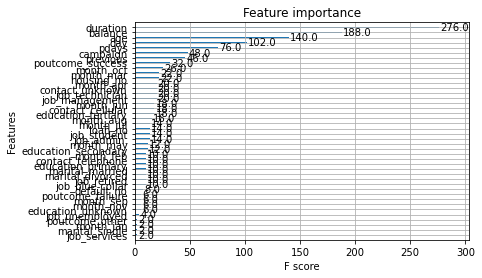

In [30]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(XGB_Model)
pyplot.show()

# Improving Boosted Model

## Creating HDR Slices

In [31]:
def f1(TP,TN,FP,FN):
  return TP/(TP+0.5*(FN+FP)) 

def recall(TP,TN,FP,FN):
  return TP/(TP+FN) 

def precision(TP,TN,FP,FN):
  return TP/(TP+FP) 

def f_beta(TP,TN,FP,FN, beta):
  return ((1+beta*beta)*TP)/((1+beta*beta)*TP+beta*beta*FN+0.5*FP) 

def f_half(TP,TN,FP,FN):
  return f_beta(TP,TN,FP,FN,0.5)

In [32]:
def confusion_metrics(row):
    if row['y'] == 1 and row['y_pred'] == 0:
        val = 'FN'
    elif row['y'] == 0 and row['y_pred'] == 1:
        val = 'FP'
    elif row['y'] == 1:
        val = 'TP'
    else:
        val = 'TN'

    return val

In [33]:
# generalized function for comparing accuracy
def compare_acc(dfx, dfy, y_pred, sl):
    feat = sl[0][0]
    if sl[0][1] is None:
        indexes = np.arange(dfx.index[:][-1])
    elif type(sl[0][1]) == list:
        hdr_min, hdr_max = sl[0][1][0], sl[0][1][1]
        if hdr_min == hdr_max:
            indexes = dfx.index[dfx[feat] == hdr_min]
        else:
            indexes = dfx.index[dfx[feat].between(hdr_min, hdr_max)]
    else:
        indexes = dfx.index[dfx[feat] == sl[0][1]]
    test_acc = np.sum(y_pred == np.array(dfy.values)[:,0]) / len(y_pred)
    sub_acc = np.sum(y_pred[indexes] == np.array(dfy.loc[indexes].values)[:,0]) / len(indexes)

    dif = test_acc - sub_acc
    
    return dif, sub_acc

In [34]:
def compare_f1(dfx, y, y_pred , sl):
    feat = sl[0][0]
    
    val_total_f1 = metrics.f1_score(y, y_pred)
    
    main = pd.DataFrame()
    main[feat] = dfx[feat].copy()

    main['y_pred'] = y_pred
    main['y'] = y
    
    main['metrics'] = main.apply(confusion_metrics, axis=1)

    if type(sl[0][1]) == list:
        left = sl[0][1][0]
        right = sl[0][1][1]

        new_dfx = main.where(main[feat] >= left).where(main[feat] <= right)
        
    else:
        val = sl[0][1]
        
        new_dfx = main.where(main[feat] == val)

    TP = new_dfx[feat].where(new_dfx.metrics == 'TP').count() # always closed from right
    TN = new_dfx[feat].where(new_dfx.metrics == 'TN').count()
    FP = new_dfx[feat].where(new_dfx.metrics == 'FP').count()
    FN = new_dfx[feat].where(new_dfx.metrics == 'FN').count()
    val_slice_f1 = f1(TP,TN,FP,FN)

    dif = val_total_f1 - val_slice_f1

    return dif, val_slice_f1

In [35]:
def find_range(data,y,y_pred ,col, hdi_prob = 0.9, q1=2,q2 = 5, func = f1, baseline = 0.46): # with moving window
    # HDR
    #   print(f"Checking {col} feature:")

    main = pd.DataFrame()
    main[col] = data[col].copy()

    main['y_pred'] = y_pred
    main['y'] = y

    main['metrics'] = main.apply(confusion_metrics, axis=1)


    np_data = main[col].to_numpy()
    hdr = az.hdi(np_data, hdi_prob=hdi_prob)

    new_left = hdr[0]
    new_right = hdr[1]

    #print(f"HDR = [{new_left}, {new_right}]")


    new_data = main.where(main[col] >= new_left).where(main[col] <= new_right)

    TP = new_data[col].where(new_data.metrics == 'TP').count() # always closed from right
    TN = new_data[col].where(new_data.metrics == 'TN').count()
    FP = new_data[col].where(new_data.metrics == 'FP').count()
    FN = new_data[col].where(new_data.metrics == 'FN').count()
    acc = func(TP,TN,FP,FN)

    #print(f"HDR accuracy measure= {acc:.3f}")


    # find bigest error in HDR using pd.qcut
    slices = []
    lowest_acc = 1
    slice_to_upgrade = None
    slices_under_baseline = []
    worst_matrix = [0,0,0,0]
    n_unique = len(pd.unique(new_data[col]))

    #print(n_unique)
    if q2> n_unique/2:
        q2 = n_unique

    for q in range(q1,q2+1):
        x = pd.qcut(new_data[col], q=q, duplicates='drop').value_counts()
        #x = pd.cut(new_data, bins=q, duplicates='drop').value_counts()
        if len(x) < q:
          #print(f'not splittiable with qcut to {q} intervals')
          break


    
    
    for interval in x.index:
      left = interval.left
      right = interval.right
      TP = new_data[col].where(new_data.metrics == 'TP').where(new_data[col] > left).where(new_data[col] <= right).count() # always closed from right
      TN = new_data[col].where(new_data.metrics == 'TN').where(new_data[col] > left).where(new_data[col] <= right).count()
      FP = new_data[col].where(new_data.metrics == 'FP').where(new_data[col] > left).where(new_data[col] <= right).count()
      FN = new_data[col].where(new_data.metrics == 'FN').where(new_data[col] > left).where(new_data[col] <= right).count()
      acc = func(TP,TN,FP,FN)

      if  acc < lowest_acc: #and acc > 0:
        lowest_acc = acc
        slice_to_upgrade = interval
        worst_matrix = [TP, TN, FP, FN]

      slices.append([interval, acc, TP, TN, FP, FN])
      if acc < baseline:
        slices_under_baseline.append(interval)

  #print(f"worst slice = {slice_to_upgrade} with accuracy of {lowest_acc}")
  #print(f"(TP,TN,FP,FN) = ({worst_matrix[0]},{worst_matrix[1]},{worst_matrix[2]},{worst_matrix[3]})")

    return slices_under_baseline, slice_to_upgrade, lowest_acc, worst_matrix

In [36]:
# get list of all numeric feature slices
num_feats = []
for i, col in enumerate(data.dtypes):
    if np.issubdtype(col, np.integer):
        if data.columns[i] == 'y':
            pass
        else:
            num_feats.append(data.columns[i])

num_feats

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [37]:
df_x = X_val.reset_index(drop=True)
df_y = y_val.reset_index(drop=True)
y_pred = np.argmax(y_predict,1)

compare = y_pred == np.array(df_y.values[:,0])
bad_guesses = X_val.iloc[np.where(compare == 0)[0]]

hdr_dict = {}
for feat in num_feats:
    _, slice_to_upgrade, _, _ = find_range(df_x,df_y,y_pred ,col = feat)
    if slice_to_upgrade == None:
        pass
    else:
        hdr_dict[feat] = [slice_to_upgrade.left + .0001, slice_to_upgrade.right]

hdr_dict

{'age': [50.0001, 59.0],
 'balance': [17.0001, 245.0],
 'day': [3.9991000000000003, 8.0],
 'duration': [4.999099999999999, 78.0],
 'campaign': [0.9991, 2.0],
 'pdays': [-1.0009, 184.0],
 'previous': [-0.0009, 2.0]}

## Creating All Slices

In [38]:
from itertools import combinations
# generate slices
feats_and_vals = []
for feat in X_train.columns:
    # for numeric features only create slices in hdr
    if feat in num_feats:
        if feat not in hdr_dict.keys():
            pass
        else:
            feats_and_vals.append([feat, hdr_dict[feat]])
    # for categorical features, create slices for each unique value
    else:
        for val in X_train[feat].unique():
            if val == 0:
                pass
            else:
                feats_and_vals.append([feat, val])

combos = list(combinations(feats_and_vals,1))
combos

[(['age', [50.0001, 59.0]],),
 (['balance', [17.0001, 245.0]],),
 (['day', [3.9991000000000003, 8.0]],),
 (['duration', [4.999099999999999, 78.0]],),
 (['campaign', [0.9991, 2.0]],),
 (['pdays', [-1.0009, 184.0]],),
 (['previous', [-0.0009, 2.0]],),
 (['job_admin.', 1],),
 (['job_blue-collar', 1],),
 (['job_entrepreneur', 1],),
 (['job_housemaid', 1],),
 (['job_management', 1],),
 (['job_retired', 1],),
 (['job_self-employed', 1],),
 (['job_services', 1],),
 (['job_student', 1],),
 (['job_technician', 1],),
 (['job_unemployed', 1],),
 (['job_unknown', 1],),
 (['marital_divorced', 1],),
 (['marital_married', 1],),
 (['marital_single', 1],),
 (['education_primary', 1],),
 (['education_secondary', 1],),
 (['education_tertiary', 1],),
 (['education_unknown', 1],),
 (['default_no', 1],),
 (['default_yes', 1],),
 (['housing_no', 1],),
 (['housing_yes', 1],),
 (['loan_no', 1],),
 (['loan_yes', 1],),
 (['contact_cellular', 1],),
 (['contact_telephone', 1],),
 (['contact_unknown', 1],),
 (['mon

## Filtering Problematic Slices

In [39]:
def test_error(prob_slice):
    feat = prob_slice[0][0]
    
    if type(prob_slice[0][1]) == list:
        hdr_min, hdr_max = prob_slice[0][1][0], prob_slice[0][1][1]
        if hdr_min == hdr_max:
            test_error = len(bad_guesses[bad_guesses[feat] == hdr_min]) / len(bad_guesses)
        else:
            test_error = len(bad_guesses[bad_guesses[feat].between(hdr_min, hdr_max)]) / len(bad_guesses)
    else:
        val = prob_slice[0][1]
        test_error = len(bad_guesses[bad_guesses[feat] == val]) / len(bad_guesses)
    
    return test_error

In [40]:
# check importance of slices
prob_slices = []
for sl in combos:
    dif, acc = compare_f1(df_x, df_y, y_pred, sl)
    if dif > sig:
        error = test_error(sl)
        if error >= min_support:
            prob_slices.append([sl, acc, error])

prob_slices

<ipython-input-31-4130b5d8292b>:2: RuntimeWarning: invalid value encountered in true_divide
  return TP/(TP+0.5*(FN+FP))


[[(['age', [50.0001, 59.0]],), 0.23529411764705882, 0.18571428571428572],
 [(['balance', [17.0001, 245.0]],), 0.2857142857142857, 0.07142857142857142],
 [(['day', [3.9991000000000003, 8.0]],),
  0.3157894736842105,
  0.18571428571428572],
 [(['previous', [-0.0009, 2.0]],), 0.3883495145631068, 0.9],
 [(['job_management', 1],), 0.36363636363636365, 0.2],
 [(['job_retired', 1],), 0.375, 0.14285714285714285],
 [(['job_student', 1],), 0.0, 0.05714285714285714],
 [(['job_technician', 1],), 0.2962962962962963, 0.2714285714285714],
 [(['marital_divorced', 1],), 0.0, 0.21428571428571427],
 [(['education_tertiary', 1],), 0.358974358974359, 0.35714285714285715],
 [(['education_unknown', 1],), 0.2857142857142857, 0.07142857142857142],
 [(['contact_cellular', 1],), 0.4, 0.8571428571428571],
 [(['month_feb', 1],), 0.0, 0.08571428571428572],
 [(['month_jan', 1],), 0.2857142857142857, 0.07142857142857142],
 [(['month_may', 1],), 0.38461538461538464, 0.22857142857142856],
 [(['month_nov', 1],), 0.28571

## Adding numeric feature to prob slices

## Generating new data for all problem slices

In [39]:
def synthesize(prob_slice, X, y, cat_feats):
    # extract info from prob slice
    prob = prob_slice
    
    prob_slice = prob[0][0][0]
    cat = '_' in prob_slice
    if cat:
        prob_slice = prob_slice.split('_')

        prob_feat, prob_val = prob_slice[0], prob_slice[1]
        
    else:
        prob_feat = prob_slice
        left, right = prob[0][0][1]
        

    # factorize dataset 
    data_fact = X.copy(deep=True)
    data_fact['y'] = y

    unique_dict = {}
    for feat in cat_feats:
        data_fact[feat], unique_dict[feat] = pd.factorize(data_fact[feat])
        
    if cat:
        # identify factorized values of prob_val and most frequent_val
        freqs = data_fact[prob_feat].value_counts(sort=False).sort_index(ascending=True)
        top_fact_val = freqs.argmax()
        prob_fact_val = unique_dict[prob_feat].get_loc(prob_val)
        if top_fact_val == prob_fact_val:
    #         raise Exception(f"For feature: {prob_feat}, the prob_val: {prob_val} is also the most frequent val") 
            synth_X, synth_y = None, None    
            return synth_X, synth_y
    else:
        pass
    
    # initialize synthesize function
    ada = ADASYN(random_state=42, n_neighbors=neighbs)
    if cat:
        # extract data only with 2 identified values
        data_ret = data_fact.loc[data_fact[prob_feat].isin([top_fact_val, prob_fact_val])]
    else:
        sl_df = data_fact[data_fact[prob_feat].between(left, right)]
        sl_size = len(sl_df)

        p = sl_size / len(data_fact)
        compare_p = 2 * p
        compare_size = int(len(data_fact) * compare_p)

        filter_df = data_fact[~data_fact[prob_feat].between(left, right)]
        if len(filter_df) > compare_size:
            filter_df = filter_df.sample(n=compare_size)
    
        data_ret = sl_df.append(filter_df)

        data_ret[f'actual_{prob_feat}'] = data_ret[prob_feat]
        data_ret[prob_feat] = np.where(data_ret[prob_feat].between(left,right), 'in', data_ret[prob_feat])
        data_ret[prob_feat] = np.where(data_ret[prob_feat] != 'in', 'out', data_ret[prob_feat])
        data_ret[prob_feat] = np.where(data_ret[prob_feat] == 'in', 1, data_ret[prob_feat])
        data_ret[prob_feat] = np.where(data_ret[prob_feat] != 1, 0, data_ret[prob_feat])
        
    # synthesize data after switching y to prob_feat
    y_train = data_ret[prob_feat]
    x_train = data_ret.drop([prob_feat],axis=1)
    y_train=y_train.astype('int')
    print(prob_feat)
    X_train_ada_feat, y_train_ada_feat = ada.fit_resample(x_train, y_train)
    
    # add prob_feat back to X in appropriate column
    idx = X.columns.get_loc(prob_feat)
    df_ada = X_train_ada_feat.copy()
    if cat:
        df_ada.insert(idx, prob_feat, y_train_ada_feat)
    else:
        df_ada = df_ada.drop(f'actual_{prob_feat}', axis=1)
        df_ada.insert(idx, prob_feat, X_train_ada_feat[f'actual_{prob_feat}'])

    # convert factorized values back to categorical values
    synth_df = df_ada.copy()
    for feat in cat_feats:
        synth_df[feat] = unique_dict[feat][synth_df[feat]]

    # seperate real y from X
    synth_y = synth_df['y']
    synth_X = synth_df.drop('y', axis=1)
        
    # check to make sure original data and first N rows of synth data are the same
    if cat:
        top_val = unique_dict[prob_feat][top_fact_val]
        data_og = X.loc[X[prob_feat].isin([top_val, prob_val])]

        data_og = data_og.reset_index(drop=True)

        N = len(data_og)
        synth_X_top = synth_X.iloc[:N]

        check = synth_X_top.equals(data_og)
        if not check:
            raise Exception(f"There is an issue with the synthesised data for feature: {prob_feat} at value: {prob_val}") 
    
    else:
        N = len(x_train)

    # exract only synthetic data from dataset
    synth_X = synth_X.iloc[N:]
    synth_y = synth_y.iloc[N:]
    
    return synth_X, synth_y

In [40]:
X, y = X_train_raw.copy(), y_train.copy()
cat_feats = cat_feats

synth_data = {}
for sl in prob_slices:
    synth_data[f'{sl}'] = synthesize(sl, X, y, cat_feats)

age
balance
day
previous
job
job
job
marital
education
education
month
month
month
poutcome


## Adding synthesized data to training set

In [41]:
X_train_new, y_train_new = X_train_raw.copy(), y_train.copy()

for dfs in synth_data.values():
    if dfs[0] is None:
        pass
    else:
        X_train_new = X_train_new.append(dfs[0])
        y_train_new = y_train_new.append(dfs[1].to_frame())

In [42]:
X_train_new = pd.get_dummies(X_train_new, columns=cat_feats)
len(X_train_new), len(X_train_raw)

(17267, 3164)

## Retraining model with new training set

In [43]:
dtrain = xgb.DMatrix(X_train_new, label=y_train_new)
dtest = xgb.DMatrix(X_test)

watchlist = [(dtrain, 'train'),(dtest, 'val')]

#Train the model
params = {
    'objective':'multi:softprob',
#     'objective':'multi:mlogloss',
    'max_dept':4,
    'silent':1,
    'eta':0.3,
    'gamma': 0,
    'num_class': 2
}
num_rounds=20

XGB_Model = xgb.train(params,dtrain,num_rounds)

XGB_Model.dump_model('dump.rawBank.txt')

y_predict_test = XGB_Model.predict(dtest)

y_predict_assignment = np.argmax(y_predict_test, 1).reshape([-1,1])
test_acc_synth = np.sum(y_predict_assignment == np.array(y_test)) / len(y_predict_test)
test_acc_synth

[13:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_dept", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8924889543446245

## Regular Boosted Model Performance on Test Set

In [44]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

watchlist = [(dtrain, 'train'),(dtest, 'val')]

#Train the model
params = {
    'objective':'multi:softprob',
#     'objective':'multi:mlogloss',
    'max_dept':4,
    'silent':1,
    'eta':0.3,
    'gamma': 0,
    'num_class': 2
}
num_rounds=20

XGB_Model = xgb.train(params,dtrain,num_rounds)

XGB_Model.dump_model('dump.rawBank.txt')

y_predict_test = XGB_Model.predict(dtest)

y_predict_assignment = np.argmax(y_predict_test, 1).reshape([-1,1])
test_acc_reg = np.sum(y_predict_assignment == np.array(y_test)) / len(y_predict_test)
test_acc_reg

[13:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_dept", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8998527245949927

## Conclusion from attempted improvements

In [45]:
print(f'The model with our modifications improved the xgboost model by {(test_acc_synth - test_acc_reg)* 100} percent')

The model with our modifications improved the xgboost model by -0.7363770250368162 percent


# Creating HDR Slices Trial 1

### HDR Age

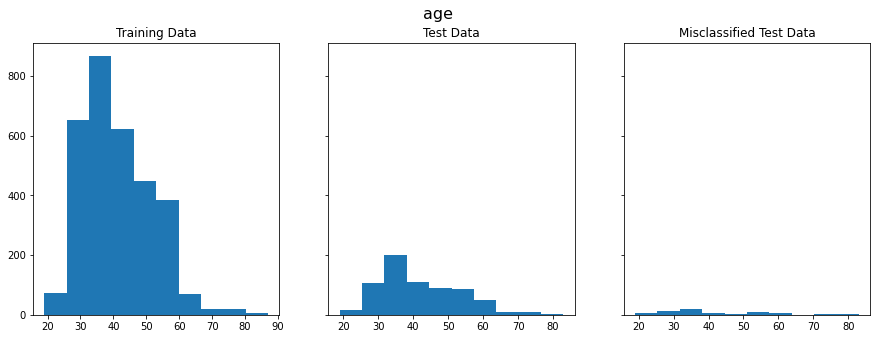

In [46]:
feature = 'age'
all_ages_train = np.array(X_train[feature])
all_ages_test = np.array(X_val[feature])

# for each numeric feature, extract hdr in misclassified test data
compare = y_pred == np.array(df_y.values)[:,0]
bad_guesses = np.where(compare == 0)[0]
bad_ages = np.array(X_val.iloc[bad_guesses][feature])

# plotting distribution of age
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

ax[0].set_title("Training Data")
ax[0].hist(all_ages_train)

ax[1].set_title("Test Data")
ax[1].hist(all_ages_test)

ax[2].set_title("Misclassified Test Data")
ax[2].hist(bad_ages)

fig.suptitle(feature, fontsize=16)
plt.show()

In [47]:
# finding hdr of misclassified age using kde
# bandwith and cutoff are parameters that can be played with
kde = KernelDensity(kernel="gaussian", bandwidth=.35).fit(bad_ages.reshape(-1,1))
log_dens = kde.score_samples(bad_ages.reshape(-1,1))

cutoff = -3
hdr_vals = bad_ages[np.where(log_dens>cutoff)]
hdr = [hdr_vals.min(), hdr_vals.max()]
hdr

[28, 36]

In [48]:
# comparing accuracy of test subset with age in hdr of misclassified samples vs overall test set accuracy
indexes = df_x.index[df_x[feature].between(hdr[0], hdr[1])]

ages_hdr_acc = np.sum(y_pred == np.array(df_y.loc[indexes].values[:,0])) / len(indexes)

ages_hdr_acc, test_acc

C:\Users\User\AppData\Local\Temp/ipykernel_22588/2600676598.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  ages_hdr_acc = np.sum(y_pred == np.array(df_y.loc[indexes].values[:,0])) / len(indexes)


(0.0, 0.8967551622418879)

## Old HDR Implementation

In [49]:
# generalized function for finding hdr of  feature among misclassified samples
def extract_hdr(df, feature, bandwidth=bw, cutoff=cf):

    feat_array = np.array(df[feature])

    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(feat_array.reshape(-1,1))
    log_dens = kde.score_samples(feat_array.reshape(-1,1))

    cutoff = cutoff
    hdr_vals = feat_array[np.where(log_dens>cutoff)]
    if len(hdr_vals) > 0:
        hdr = [hdr_vals.min(), hdr_vals.max()]
    else:
        hdr = None
    return hdr

In [50]:
# generalized function for comparing accuracy
def compare_acc(dfx, dfy, y_pred, sl):
    feat = sl[0][0]
    if sl[0][1] is None:
        indexes = np.arange(dfx.index[:][-1])
    elif type(sl[0][1]) == list:
        hdr_min, hdr_max = sl[0][1][0], sl[0][1][1]
        if hdr_min == hdr_max:
            indexes = dfx.index[dfx[feat] == hdr_min]
        else:
            indexes = dfx.index[dfx[feat].between(hdr_min, hdr_max)]
    else:
        indexes = dfx.index[dfx[feat] == sl[0][1]]
    test_acc = np.sum(np.argmax(y_pred,1) == np.array(dfy.values[:,1])) / len(y_pred)
    sub_acc = np.sum(np.argmax(y_pred[indexes],1) == np.array(dfy.loc[indexes].values[:,1])) / len(indexes)

    dif = test_acc - sub_acc
    
    return dif, sub_acc

In [51]:
# get list of all numeric feature slices
num_feats = []
for i, col in enumerate(data.dtypes):
    if np.issubdtype(col, np.integer):
        if data.columns[i] == 'y':
            pass
        else:
            num_feats.append(data.columns[i])

num_feats

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [52]:
df_x = X_val.reset_index()
df_y = y_val.reset_index()

# for each numeric feature, extract hdr in misclassified test data
compare = np.argmax(y_predict,1) == np.array(df_y.values[:,1])
bad_guesses = X_val.iloc[np.where(compare == 0)[0]]

hdr_dict = {}
for feat in num_feats:
    hdr_dict[feat] = extract_hdr(bad_guesses, feat)

hdr_dict

{'age': [28, 36],
 'balance': [0, 0],
 'day': [5, 28],
 'duration': None,
 'campaign': [1, 5],
 'pdays': [-1, -1],
 'previous': [0, 3]}

# Generating new data for problem slice Trial 1

## creating new dataframe

In [53]:
prob_slice = prob_slices[1]
prob_slice

[(['balance', [17.0001, 245.0]],), 0.2857142857142857, 0.07142857142857142]

In [54]:
feat = prob_slice[0][0][0]
keyword = feat.split('_')[0]
keyword

'balance'

In [55]:
cols_to_remove = []
for col in X_train.columns:
    if keyword in col:
        cols_to_remove.append(col)
cols_to_remove        

['balance']

In [56]:
new_df = X_train.copy()
new_df['y'] = y_train
new_df_y = new_df[feat]
new_df = new_df.drop(columns=cols_to_remove)
new_df.head()

,age,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
205,45,18,139,2,-1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2784,35,4,164,2,167,4,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2834,59,13,119,2,-1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
799,53,28,332,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1868,42,6,159,1,343,2,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [57]:
new_df_y

205        0
2784    5731
2834     235
799     1012
1868    -679
        ... 
111     1517
159     1641
2287    1449
3773      47
4349    2131
Name: balance, Length: 3164, dtype: int64

## generating new data based on new dataframe

## adding synthesized data to old dataframe

In [58]:
synth_df = new_df.loc[new_df_y.index[new_df_y == 1]]

og_df = synth_df
og_df[cols_to_remove] = 0
og_df[feat] = 1

og_df_y = og_df['y']
og_df.drop(columns = ['y'])

og_df.head()

,age,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y,balance
1178,27,14,116,3,-1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1261,30,22,80,2,-1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2803,37,15,395,2,-1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3428,29,18,167,3,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
197,38,21,152,2,-1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


In [59]:
og_og = X_train.copy()
og_og

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
205,45,0,18,139,2,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2784,35,5731,4,164,2,167,4,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2834,59,235,13,119,2,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
799,53,1012,28,332,2,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1868,42,-679,6,159,1,343,2,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,58,1517,29,7,5,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
159,34,1641,17,380,1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2287,38,1449,26,535,6,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3773,34,47,25,132,6,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [60]:
dfs = [og_og, og_df]
result = pd.concat(dfs)
result.tail()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
2234,34,1,19,108,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0.0
1630,32,1,8,399,4,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0.0
240,34,1,22,483,7,-1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.0
750,57,1,15,17,10,-1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0.0
573,81,1,19,65,5,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0


In [61]:
result.iloc[-1]

age                    81.0
balance                 1.0
day                    19.0
duration               65.0
campaign                5.0
pdays                  -1.0
previous                0.0
job_admin.              0.0
job_blue-collar         0.0
job_entrepreneur        0.0
job_housemaid           0.0
job_management          0.0
job_retired             1.0
job_self-employed       0.0
job_services            0.0
job_student             0.0
job_technician          0.0
job_unemployed          0.0
job_unknown             0.0
marital_divorced        0.0
marital_married         1.0
marital_single          0.0
education_primary       0.0
education_secondary     1.0
education_tertiary      0.0
education_unknown       0.0
default_no              1.0
default_yes             0.0
housing_no              1.0
housing_yes             0.0
loan_no                 1.0
loan_yes                0.0
contact_cellular        1.0
contact_telephone       0.0
contact_unknown         0.0
month_apr           

# Generating new data for problem slice Trial 2

## Generate Synthetic data on original dataset 

In [62]:
prob = prob_slices[6]
prob

[(['job_student', 1],), 0.0, 0.05714285714285714]

In [63]:
prob_slice = prob[0][0][0]
prob_slice = prob_slice.split('_')
prob_feat = prob_slice[0]
prob_val = prob_slice[1]

prob_feat, prob_val

('job', 'student')

In [64]:
# factorize dataset 
data_fact = X_train_raw.copy(deep=True)
data_fact['y'] = y_train

unique_dict = {}
for feat in cat_feats:
    data_fact[feat], unique_dict[feat] = pd.factorize(data_fact[feat])

In [65]:
data_fact

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
205,45,0,0,0,0,0,0,0,0,18,0,139,2,-1,0,0,0
2784,35,0,0,1,0,5731,0,0,0,4,1,164,2,167,4,1,0
2834,59,1,1,2,0,235,1,0,0,13,2,119,2,-1,0,0,0
799,53,2,2,3,0,1012,0,0,0,28,3,332,2,-1,0,0,0
1868,42,3,1,2,0,-679,0,1,0,6,1,159,1,343,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,58,3,1,0,0,1517,0,0,2,29,3,7,5,-1,0,0,0
159,34,0,1,1,0,1641,0,0,0,17,7,380,1,-1,0,0,0
2287,38,8,1,0,0,1449,1,0,1,26,1,535,6,-1,0,0,0
3773,34,0,1,1,0,47,1,0,0,25,2,132,6,-1,0,0,0


In [66]:
freqs = data_fact[prob_feat].value_counts(sort=False).sort_index(ascending=True)
freqs

0     533
1      81
2     301
3     695
4      62
5     323
6     651
7     152
8      82
9     122
10     27
11    135
Name: job, dtype: int64

In [67]:
top_fact_val = freqs.argmax()
prob_fact_val = unique_dict[prob_feat].get_loc(prob_val)

top_fact_val, prob_fact_val

(3, 4)

In [68]:
from imblearn.over_sampling import ADASYN
from collections import Counter

ada = ADASYN(random_state=42)

data_ret = data_fact.loc[data_fact[prob_feat].isin([top_fact_val, prob_fact_val])]

X_train_ada_feat, y_train_ada_feat = ada.fit_resample(data_ret.drop([prob_feat],axis=1), data_ret[prob_feat])

print(f'Before: {Counter(data_fact[prob_feat])}\nSmenn: {Counter(y_train_ada_feat)}')

Before: Counter({3: 695, 6: 651, 0: 533, 5: 323, 2: 301, 7: 152, 11: 135, 9: 122, 8: 82, 1: 81, 4: 62, 10: 27})
Smenn: Counter({3: 695, 4: 691})


In [69]:
# join X_train and y_train
# df_ada = X_train_ada_feat.join(y_train_ada_feat)
idx = X_train_raw.columns.get_loc(prob_feat)
df_ada = X_train_ada_feat.copy()
df_ada.insert(idx, prob_feat, y_train_ada_feat)

synth_df = df_ada.copy()

for feat in cat_feats:
    synth_df[feat] = unique_dict[feat][synth_df[feat]]

synth_y = synth_df['y']
synth_X = synth_df.drop('y', axis=1)

top_val = unique_dict[prob_feat][top_fact_val]
data_og = X_train_raw.loc[X_train_raw[prob_feat].isin([top_val, prob_val])]
data_og = data_og.reset_index(drop=True)

N = len(data_og)
synth_X_top = synth_X.iloc[:N]

check = synth_X_top.equals(data_og)
if not check:
   raise Exception(f"There is an issue with the synthesised data for feature: {prob_feat} at value: {prob_val}") 

synth_X = synth_X.iloc[N:]
synth_y = synth_y.iloc[N:]

In [70]:
# join X_train and y_train
# df_ada = X_train_ada_feat.join(y_train_ada_feat)
idx = X_train_raw.columns.get_loc(prob_feat)
df_ada = X_train_ada_feat.copy()
df_ada.insert(idx, prob_feat, y_train_ada_feat)

# remove job == 2, 10 because it's included in the generated data 
data_fact = data_fact.loc[~data_fact[prob_feat].isin([top_fact_val, prob_fact_val])]

# append synthetic data to original dataset 
data_fact = data_fact.append(df_ada)

In [71]:
# convert back to categorical data 
for feat in cat_feats:
    print(feat)
    data_fact[feat] = unique_dict[feat][data_fact[feat]]

job
marital
education
default
housing
loan
contact
month
poutcome


In [72]:
data_fact

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
205,45,technician,single,tertiary,no,0,yes,no,cellular,18,nov,139,2,-1,0,unknown,0
2784,35,technician,single,secondary,no,5731,yes,no,cellular,4,may,164,2,167,4,other,0
2834,59,housemaid,married,primary,no,235,no,no,cellular,13,aug,119,2,-1,0,unknown,0
799,53,services,divorced,unknown,no,1012,yes,no,cellular,28,jul,332,2,-1,0,unknown,0
427,26,technician,married,tertiary,no,3825,yes,no,unknown,13,may,107,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,29,student,single,secondary,no,3112,no,no,cellular,25,jan,132,1,7,0,unknown,0
1382,28,student,single,secondary,no,3147,no,no,cellular,25,jan,151,1,24,0,unknown,0
1383,25,student,single,secondary,no,2743,yes,no,cellular,7,aug,565,1,34,0,unknown,0
1384,27,student,single,secondary,no,3225,no,no,cellular,23,apr,195,1,62,1,unknown,0


# End of synthesizing

In [73]:
synth_df = df_ada.copy()

for feat in cat_feats:
    synth_df[feat] = unique_dict[feat][synth_df[feat]]

synth_y = synth_df['y']
synth_df = synth_df.drop('y', axis=1)
synth_df

top_val = unique_dict[prob_feat][top_fact_val]
data_og = X_train_raw.loc[X_train_raw[prob_feat].isin([top_val, prob_val])]
data_og = data_og.reset_index(drop=True)

N = len(data_og)
synth_df_top = synth_df.iloc[:N]
synth_df_top.equals(data_og)

True

In [74]:
synth_df_bottom = synth_df.iloc[N:]
synth_df_bottom

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
757,36,student,married,primary,no,0,yes,no,cellular,17,jul,118,1,-1,0,unknown
758,30,student,single,secondary,no,24,no,no,unknown,29,jan,45,1,-1,0,unknown
759,32,student,single,tertiary,no,0,no,no,cellular,6,aug,101,4,2,5,unknown
760,32,student,single,secondary,no,17,no,no,unknown,26,jan,65,1,-1,0,unknown
761,33,student,single,secondary,no,13,no,no,unknown,24,feb,76,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,29,student,single,secondary,no,3112,no,no,cellular,25,jan,132,1,7,0,unknown
1382,28,student,single,secondary,no,3147,no,no,cellular,25,jan,151,1,24,0,unknown
1383,25,student,single,secondary,no,2743,yes,no,cellular,7,aug,565,1,34,0,unknown
1384,27,student,single,secondary,no,3225,no,no,cellular,23,apr,195,1,62,1,unknown


In [75]:
synth_y.iloc[N:].unique()

array([0, 1], dtype=int64)

In [76]:
synth_df_bottom['job'].unique()

array(['student'], dtype=object)

## Generating Synthetic Data Using CTGAN

In [60]:
def extract_discrete_columns_from_data(data, threshold=20):
    column_uniques = data.nunique()
    column_names = data.columns
    discrete_columns = []
    
    for col_index, num_of_uniques in enumerate(column_uniques):
        if num_of_uniques < threshold: # Any column with less unique values than the trheshold is considered discrete
            discrete_columns.append(column_names[col_index])
    
    return discrete_columns

# This does weird things...
def comare_data_with_synthetic(data, synthetic):
    from table_evaluator import load_data, TableEvaluator
    table_evaluator = TableEvaluator(data, synthetic)
    table_evaluator.visual_evaluation()

def generate_synthetic_data_from_slice(data, num_samples_to_generate, num_epochs=10, 
                                       discrete_columns=None, should_compare=False):
    if discrete_columns is None:
        discrete_columns = extract_discrete_columns_from_data(data)
        
    ctgan = CTGANSynthesizer(epochs=num_epochs)
    ctgan.fit(data, discrete_columns)
    
    samples = ctgan.sample(num_samples_to_generate)
    
    if should_compare:
        comare_data_with_synthetic(data, samples)
    
    return samples

In [86]:
print(data.shape)
print(data.head())

synthetic_data = generate_synthetic_data_from_slice(data, 1000)

synthetic_data.head()

(4521, 17)
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  y  
0  cellular   19   oct        79         1     -1         0  unknown  0  
1  cellular   11   may       220         1    339         4  failure  0  
2  cellular   16   apr       185         1    330         1  failure  0  
3   unknown    3   jun       199         4     -1         0  unknown  0  
4   unknown    5   may       226         1     -1         0  unknown  0  


C:\Users\User\anaconda3\envs\MLOpsProject\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\User\anaconda3\envs\MLOpsProject\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\User\anaconda3\envs\MLOpsProject\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\User\anaconda3\envs\MLOpsProject\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not conv

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,56,services,divorced,tertiary,no,-540,yes,no,cellular,13,aug,120,0,1,0,unknown,0
1,51,management,single,secondary,no,-346,no,yes,unknown,24,may,65,2,415,0,unknown,0
2,47,admin.,married,secondary,no,67,no,no,cellular,22,may,655,4,0,0,unknown,0
3,66,services,married,tertiary,no,-572,yes,no,cellular,11,aug,80,3,-3,0,unknown,0
4,39,blue-collar,divorced,tertiary,no,1258,yes,yes,cellular,23,nov,191,5,0,0,unknown,0


In [56]:
prob_slices[0][0][0][0]

'age'

In [74]:
!pip install table_evaluator

  Using cached table_evaluator-1.3.2-py3-none-any.whl (20 kB)
  Using cached dython-0.5.1-py3-none-any.whl (14 kB)


In [76]:
data_to_synthesize = train_df_cp[(train_df_cp[prob_slices[0][0][0][0]] >= prob_slices[0][0][0][1][0]) & 
                                 (train_df_cp[prob_slices[0][0][0][0]] <= prob_slices[0][0][0][1][1])]
generated_age = generate_synthetic_data_from_slice(data_to_synthesize, 200)

C:\Users\User\anaconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [77]:
generated_age['job'].value_counts()

self-employed    27
housemaid        25
services         20
retired          20
technician       19
entrepreneur     18
unemployed       18
blue-collar      16
unknown          15
admin.           12
management       10
Name: job, dtype: int64

In [66]:

train_df_cp = X_train_raw.copy(deep=True)
train_lable_df_cp = y_train.copy(deep=True)
train_df_cp['y'] = train_lable_df_cp
train_df_cp

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
205,45,technician,single,tertiary,no,0,yes,no,cellular,18,nov,139,2,-1,0,unknown,0
2784,35,technician,single,secondary,no,5731,yes,no,cellular,4,may,164,2,167,4,other,0
2834,59,housemaid,married,primary,no,235,no,no,cellular,13,aug,119,2,-1,0,unknown,0
799,53,services,divorced,unknown,no,1012,yes,no,cellular,28,jul,332,2,-1,0,unknown,0
1868,42,management,married,primary,no,-679,yes,yes,cellular,6,may,159,1,343,2,failure,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,58,management,married,tertiary,no,1517,yes,no,telephone,29,jul,7,5,-1,0,unknown,0
159,34,technician,married,secondary,no,1641,yes,no,cellular,17,apr,380,1,-1,0,unknown,0
2287,38,unemployed,married,tertiary,no,1449,no,no,unknown,26,may,535,6,-1,0,unknown,0
3773,34,technician,married,secondary,no,47,no,no,cellular,25,aug,132,6,-1,0,unknown,0


In [84]:
def generate_synthetic_data_for_problematic_slices(x_train_raw_df, y_train_df, prob_slices_lst, percent_to_generate=0.5):
    train_df_cp = x_train_raw_df.copy(deep=True)
    y_train_df_cp = y_train_df.copy(deep=True)
    train_df_cp['y'] = y_train_df_cp
    
    print(train_df_cp.shape)
    
    generated_samples_dict = {}
    
    for prob_slice in prob_slices_lst:
        column_name = prob_slice[0][0][0]
        key = column_name
        
        is_categorical = '_' in column_name
        
        if is_categorical:
            split_col = column_name.split('_')
            column_name, column_value = split_col[0], split_col[1]
        else:
            prob_feat = prob_slice
            column_from_val, column_to_val = prob_slice[0][0][1]
        
        #print(f'column_name: {column_name}, column_from_val: {column_from_val}, column_to_val: {column_to_val}')
        if is_categorical:
            prob_df = train_df_cp[train_df_cp[column_name] == column_value]
        else:
            prob_df = train_df_cp[(train_df_cp[column_name] >= column_from_val) & 
                                  (train_df_cp[column_name] <= column_to_val)]
        
        num_to_generate = int(len(prob_df) * percent_to_generate)
        
        generated_samples = generate_synthetic_data_from_slice(prob_df, num_to_generate)
        
        generated_samples_y = pd.DataFrame(generated_samples['y'])
        generated_samples_x = generated_samples.drop(['y'], axis=1)
        
        generated_samples_dict[key] = (generated_samples_x, generated_samples_y)
        
    return generated_samples_dict

In [85]:
generated_samples_dict = generate_synthetic_data_for_problematic_slices(X_train_raw, y_train, prob_slices)

(3164, 17)


C:\Users\User\anaconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\mixture\_base.py:277: Conv

In [86]:
generated_samples_dict

{'age': (     age            job   marital  education default  balance housing loan  \
  0     56      housemaid    single  secondary      no    18947     yes  yes   
  1     52   entrepreneur    single    primary     yes     -120      no   no   
  2     59  self-employed    single    primary      no     2692      no  yes   
  3     54        retired    single  secondary     yes     9936     yes  yes   
  4     55        unknown   married  secondary      no     2501     yes  yes   
  ..   ...            ...       ...        ...     ...      ...     ...  ...   
  249   51  self-employed   married    primary      no    24856      no  yes   
  250   57        unknown  divorced   tertiary      no    28647      no   no   
  251   59         admin.  divorced  secondary      no     7978     yes   no   
  252   52        unknown   married  secondary      no     -105     yes   no   
  253   53     management   married    unknown     yes      152     yes  yes   
  
         contact  day month  d